In [20]:
import pandas as pd
import numpy as np
import os
import warnings
import pickle
import os.path
import seaborn
import pickle
import os.path
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import random

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']

import seaborn as sns
#sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
#plt.style.use('ggplot')
mpl.rc('xtick', labelsize=40) 
mpl.rc('ytick', labelsize=40) 
%matplotlib inline

In [21]:
os.chdir("/home/zhh/文档/阿里巴巴/data/")
os.listdir()

['提交结果20170810.csv',
 '2联表',
 'fee_detail.csv',
 '3.分析train和train_id',
 '提交结果201708100130.csv',
 'df_test.csv',
 'df_id_train.csv',
 '6.合表新周索引.pickle',
 'df_train.csv',
 '1数据读入',
 '6.合表',
 'df_id_test.csv',
 '.~lock.df_train.csv#',
 '4.分析fee_detail',
 '.~lock.df_test.csv#',
 '精准社保各数据集字段',
 '7测试表合表']

In [3]:
#读取测试集
data = pd.read_csv("df_test.csv")

/home/zhh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (56,58,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
data.head()

,顺序号,个人编码,医院编码,药品费发生金额,贵重药品发生金额,中成药费发生金额,中草药费发生金额,药品费自费金额,药品费拒付金额,药品费申报金额,...,出院诊断病种名称,本次审批金额,补助审批金额,医疗救助医院申请,残疾军人医疗补助基金支付金额,民政救助补助金额,城乡优抚补助金额,非典补助补助金额,家床起付线剩余,操作时间
0,MT01801607015822867,352120001207726,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,挂号,6.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,01-7月 -16
1,MT01801607015822875,352120000183777,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,挂号,3.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,01-7月 -16
2,MT01801607015822882,352120000183777,180.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,尿毒症;肾性贫血;肾性高血压;失眠;肾性骨病;肝功能异常;低蛋白血症;肾透析,450.8,NaN,0.0,NaN,0.0,0.0,0.0,0.0,01-7月 -16
3,MT13061606204620197,352120002857717,1306.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,挂号,3.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,20-6月 -16
4,MT01431607015822595,352120001492069,143.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,挂号,15.0,NaN,0.0,NaN,0.0,0.0,0.0,0.0,01-7月 -16


In [5]:
#删除空值较多的字段
data.drop(['一次性医用材料拒付金额','农民工医疗救助计算金额','残疾军人医疗补助基金支付金额',
           '公务员医疗补助基金支付金额','补助审批金额','城乡救助补助金额'],axis=1
         ,inplace= True)

In [6]:
#删除金额都是0的特征
drop_list = []
fee_columns_list = []   #用于储存含有金额字眼的特征
for i in data.columns:  #
    if '金额' in i:      #含有金额的装起来
        fee_columns_list.append(i)  
        
fee_list_copy = fee_columns_list.copy()
for i in fee_list_copy: 
    if data[i].unique().shape[0]==1:
        print(i,data[i].unique())
        drop_list.append(i)
        fee_columns_list.remove(i)
data = data.drop(drop_list,axis=1)

# 处理金额

In [7]:
#首先先将所有金额的字段全部加起来
fee_columns = []
for i in data.columns:
    if '金额' in i:
        fee_columns.append(i)
print(fee_columns)

['药品费发生金额', '贵重药品发生金额', '中成药费发生金额', '中草药费发生金额', '药品费自费金额', '药品费拒付金额', '药品费申报金额', '检查费发生金额', '贵重检查费金额', '检查费自费金额', '检查费拒付金额', '检查费申报金额', '治疗费发生金额', '治疗费自费金额', '治疗费拒付金额', '治疗费申报金额', '手术费发生金额', '手术费自费金额', '手术费拒付金额', '手术费申报金额', '床位费发生金额', '床位费拒付金额', '床位费申报金额', '医用材料发生金额', '高价材料发生金额', '医用材料费自费金额', '医用材料费拒付金额', '输全血申报金额', '成分输血自费金额', '成分输血拒付金额', '成分输血申报金额', '其它发生金额', '其它拒付金额', '其它申报金额', '一次性医用材料自费金额', '一次性医用材料申报金额', '输全血按比例自负金额', '起付线标准金额', '起付标准以上自负比例金额', '医疗救助个人按比例负担金额', '最高限额以上金额', '统筹拒付金额', '基本医疗保险统筹基金支付金额', '可用账户报销金额', '基本医疗保险个人账户支付金额', '非账户支付金额', '本次审批金额', '民政救助补助金额', '城乡优抚补助金额', '非典补助补助金额']


In [8]:
#首先先将根据个人编码对应各项金额全部加起来
fee_sum = data.groupby('个人编码')[fee_columns].sum()
fee_sum.reset_index(inplace=True)  #重设标签

In [9]:
data_fee = fee_sum.drop_duplicates()  #去重

In [10]:
#查看各个金额的空值情况
print('**********************************')
np.sum(data_fee.isnull())

**********************************


个人编码               0
药品费发生金额            0
贵重药品发生金额           0
中成药费发生金额           0
中草药费发生金额           0
药品费自费金额            0
药品费拒付金额            0
药品费申报金额            0
检查费发生金额            0
贵重检查费金额            0
检查费自费金额            0
检查费拒付金额            0
检查费申报金额            0
治疗费发生金额            0
治疗费自费金额            0
治疗费拒付金额            0
治疗费申报金额            0
手术费发生金额            0
手术费自费金额            0
手术费拒付金额            0
手术费申报金额            0
床位费发生金额            0
床位费拒付金额            0
床位费申报金额            0
医用材料发生金额           0
高价材料发生金额           0
医用材料费自费金额          0
医用材料费拒付金额          0
输全血申报金额            0
成分输血自费金额           0
成分输血拒付金额           0
成分输血申报金额           0
其它发生金额             0
其它拒付金额             0
其它申报金额             0
一次性医用材料自费金额       28
一次性医用材料申报金额       28
输全血按比例自负金额         0
起付线标准金额            0
起付标准以上自负比例金额       0
医疗救助个人按比例负担金额      0
最高限额以上金额           0
统筹拒付金额             0
基本医疗保险统筹基金支付金额     0
可用账户报销金额           0
基本医疗保险个人账户支付金额     0
非账户支付金额            0
本次审批金额       

In [11]:
def handle_outlie(column,threhold,data):
    data_md = data[column].median()  # 中位值
    print(data_md)
    new_column = data[column].map(lambda x : data_md if x> threhold else x)
    return new_column


In [12]:
#处理异常值
bad_fee_cols = [['药品费发生金额',60000],
                ['贵重药品发生金额',60000],
                ['中成药费发生金额',37000],
                ['中草药费发生金额',16000],
                ['药品费自费金额',2000],
['药品费申报金额',80000],
['检查费发生金额',8000],
['贵重检查费金额',3300],
['检查费自费金额',1600],
['检查费申报金额',5000],
['治疗费发生金额',33000],
['治疗费自费金额',2000],
['治疗费申报金额',33000],
['手术费发生金额',4000],
['手术费申报金额',5000],
['床位费发生金额',350],
['床位费申报金额',350],
['医用材料发生金额',7500],
['高价材料发生金额',7500],
['医用材料费自费金额',1600],
['其它发生金额',420],
['起付线标准金额',8000],
['起付标准以上自负比例金额',12500],
['医疗救助个人按比例负担金额',15000],
['基本医疗保险统筹基金支付金额',60000],
['可用账户报销金额',17000],
['基本医疗保险个人账户支付金额',2000],
['非账户支付金额',17500],
['本次审批金额',100000],
['民政救助补助金额',16000]]
for i in bad_fee_cols:
    data_fee[i[0]] = handle_outlie(i[0],i[1],data_fee)

11384.009999999998
840.92
2354.9049999999997
404.58000000000004
2.55
11285.05
260.0
0.0
0.0
256.0
336.0
0.0
329.0
0.0
0.0
0.0
0.0
156.2
0.0
0.0
0.0
0.0
1391.579999999999
0.0
11516.045000000006
1341.309999999999
101.88000000000001
1302.0949999999998
12962.094999999998
0.0


In [13]:
# 删除点比较少的特征
#输出金额
print(fee_columns)
jufu_list =[]
for i in fee_columns:
    if '拒付' in i:
        jufu_list.append(i)
print('**************')
print(jufu_list)

# 删除拒付项目
data_fee = data_fee.drop(jufu_list,axis=1)
data_fee.drop('非典补助补助金额',inplace=True,axis=1)


['药品费发生金额', '贵重药品发生金额', '中成药费发生金额', '中草药费发生金额', '药品费自费金额', '药品费拒付金额', '药品费申报金额', '检查费发生金额', '贵重检查费金额', '检查费自费金额', '检查费拒付金额', '检查费申报金额', '治疗费发生金额', '治疗费自费金额', '治疗费拒付金额', '治疗费申报金额', '手术费发生金额', '手术费自费金额', '手术费拒付金额', '手术费申报金额', '床位费发生金额', '床位费拒付金额', '床位费申报金额', '医用材料发生金额', '高价材料发生金额', '医用材料费自费金额', '医用材料费拒付金额', '输全血申报金额', '成分输血自费金额', '成分输血拒付金额', '成分输血申报金额', '其它发生金额', '其它拒付金额', '其它申报金额', '一次性医用材料自费金额', '一次性医用材料申报金额', '输全血按比例自负金额', '起付线标准金额', '起付标准以上自负比例金额', '医疗救助个人按比例负担金额', '最高限额以上金额', '统筹拒付金额', '基本医疗保险统筹基金支付金额', '可用账户报销金额', '基本医疗保险个人账户支付金额', '非账户支付金额', '本次审批金额', '民政救助补助金额', '城乡优抚补助金额', '非典补助补助金额']
**************
['药品费拒付金额', '检查费拒付金额', '治疗费拒付金额', '手术费拒付金额', '床位费拒付金额', '医用材料费拒付金额', '成分输血拒付金额', '其它拒付金额', '统筹拒付金额']


In [14]:
#统计值比较少的数
#对每个字段进行画图
value_less = []
for i in data_fee.columns:
    if '金额' in i:
        a = data_fee[i].unique().shape[0]
        if a <=250:  #小于250，全部删除
            value_less.append([i,a])
        print(i,'----->',a)
value_less

药品费发生金额 -----> 3953
贵重药品发生金额 -----> 1383
中成药费发生金额 -----> 3385
中草药费发生金额 -----> 2124
药品费自费金额 -----> 1833
药品费申报金额 -----> 3966
检查费发生金额 -----> 1434
贵重检查费金额 -----> 116
检查费自费金额 -----> 100
检查费申报金额 -----> 1480
治疗费发生金额 -----> 2095
治疗费自费金额 -----> 178
治疗费申报金额 -----> 1964
手术费发生金额 -----> 15
手术费自费金额 -----> 4
手术费申报金额 -----> 13
床位费发生金额 -----> 71
床位费申报金额 -----> 63
医用材料发生金额 -----> 2548
高价材料发生金额 -----> 11
医用材料费自费金额 -----> 382
输全血申报金额 -----> 1
成分输血自费金额 -----> 1
成分输血申报金额 -----> 2
其它发生金额 -----> 364
其它申报金额 -----> 1
一次性医用材料自费金额 -----> 2
一次性医用材料申报金额 -----> 2204
输全血按比例自负金额 -----> 1
起付线标准金额 -----> 31
起付标准以上自负比例金额 -----> 3966
医疗救助个人按比例负担金额 -----> 57
最高限额以上金额 -----> 1
基本医疗保险统筹基金支付金额 -----> 3991
可用账户报销金额 -----> 3990
基本医疗保险个人账户支付金额 -----> 1801
非账户支付金额 -----> 3987
本次审批金额 -----> 3991
民政救助补助金额 -----> 566
城乡优抚补助金额 -----> 4


[['贵重检查费金额', 116],
 ['检查费自费金额', 100],
 ['治疗费自费金额', 178],
 ['手术费发生金额', 15],
 ['手术费自费金额', 4],
 ['手术费申报金额', 13],
 ['床位费发生金额', 71],
 ['床位费申报金额', 63],
 ['高价材料发生金额', 11],
 ['输全血申报金额', 1],
 ['成分输血自费金额', 1],
 ['成分输血申报金额', 2],
 ['其它申报金额', 1],
 ['一次性医用材料自费金额', 2],
 ['输全血按比例自负金额', 1],
 ['起付线标准金额', 31],
 ['医疗救助个人按比例负担金额', 57],
 ['最高限额以上金额', 1],
 ['城乡优抚补助金额', 4]]

['贵重检查费金额', '检查费自费金额', '治疗费自费金额', '手术费发生金额', '手术费自费金额', '手术费申报金额', '床位费发生金额', '床位费申报金额', '高价材料发生金额', '输全血申报金额', '成分输血自费金额', '成分输血申报金额', '其它申报金额', '一次性医用材料自费金额', '输全血按比例自负金额', '起付线标准金额', '医疗救助个人按比例负担金额', '最高限额以上金额', '城乡优抚补助金额', '治疗费自费金额', '医用材料费自费金额', '民政救助补助金额']


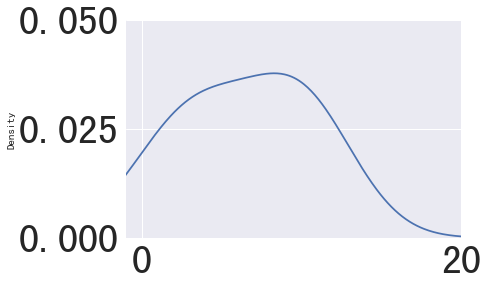

In [15]:
#将产生噪音的金额替换掉
value_less_name =[]
for i in value_less:
    #print('***************'+i[0]+'---->'+str(i[1])+'****************************')
    #print(data_fee[i[0]].value_counts().sort_index())
    value_less_name.append(i[0])
    #print('-----------------------------------------------------')
value_less_name.extend(['治疗费自费金额','医用材料费自费金额','民政救助补助金额'])
value_less_sum = data_fee[value_less_name].sum(axis=1)
np.log2(value_less_sum+0.0000001).plot('kde',xlim=[-1,20],ylim=[0,0.05])
#data_fee[value_less_name].sum(axis=1).value_counts()
data_fee['特殊金额'] = value_less_sum
print(value_less_name)
data_fee_new = data_fee.drop(value_less_name,axis=1)

In [16]:
#金额全部用来转化成log值
for i in data_fee_new:
    if '金额' in i:
        data_fee_new[i] = np.log(data_fee_new[i]+0.000001)
data_fee_new.head()

,个人编码,药品费发生金额,贵重药品发生金额,中成药费发生金额,中草药费发生金额,药品费自费金额,药品费申报金额,检查费发生金额,检查费申报金额,治疗费发生金额,...,医用材料发生金额,其它发生金额,一次性医用材料申报金额,起付标准以上自负比例金额,基本医疗保险统筹基金支付金额,可用账户报销金额,基本医疗保险个人账户支付金额,非账户支付金额,本次审批金额,特殊金额
0,352120000001598,9.171610,-13.815511,7.838375,6.543451,5.346965,9.145449,5.594711,5.594711,6.138806,...,5.134621,-13.815511,5.134621,6.934787,9.132010,6.971519,4.893202,7.040913,9.237371,-13.815511
1,352120000004806,9.154141,-13.815511,7.158031,8.114642,3.510650,9.148880,-13.815511,-13.815511,8.171882,...,-13.815511,-13.815511,-13.815511,7.165779,9.363021,7.178172,5.273000,7.046630,9.468380,-13.815511
2,352120000005123,9.347537,8.357170,6.363855,7.596473,-13.815511,9.347537,5.099866,5.099866,5.895779,...,-13.815511,2.995732,-13.815511,7.089918,9.287138,7.089918,4.735057,7.008451,9.392499,-13.815511
3,352120000006659,9.529905,8.758595,8.758595,8.909251,-13.815511,9.529905,-13.815511,-13.815511,4.262680,...,-13.815511,-13.815511,-13.815511,7.232430,9.429693,7.232430,4.553877,7.161296,9.535049,-13.815511
4,352120000010106,8.960440,-13.815511,7.951408,5.549893,-1.560643,8.957095,4.859812,4.859812,5.065755,...,5.798001,-13.815511,5.798001,6.731018,8.928231,6.761341,4.617593,6.636943,9.033592,-13.815511


In [17]:
#重置索引
data_fee_new= data_fee_new.reset_index(drop = True)

In [18]:
#药品费发生金额画出散点图
def plot_log_fee(columns,data,start=0,end=100000):

    
    fig,ax1 = plt.subplots(figsize=(15,6))
    #分布图
    sns.kdeplot(data[columns],ax=ax1,label='全部')
    #sns.distplot(data[data['标签']==0][columns],ax=ax1,kde=False,color='b',label='非骗保')
    ax1.set(title =columns,xlabel=columns,ylabel='频数',xlim=[start,end]) 
    ax1.legend()
    fig.suptitle('Fee Analysis', fontsize=20, fontweight='bold');
    #plt.savefig(columns+'.png')  #保存图像
    plt.show()

-11.1174261557


/home/zhh/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


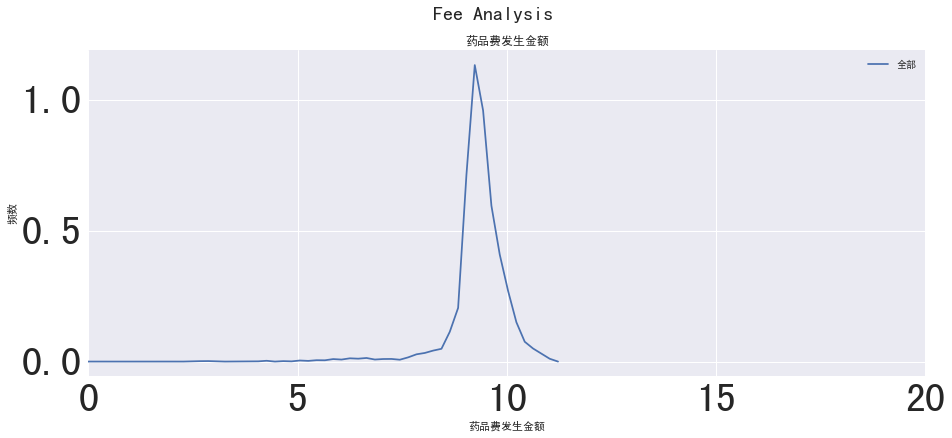

-0.281485033485


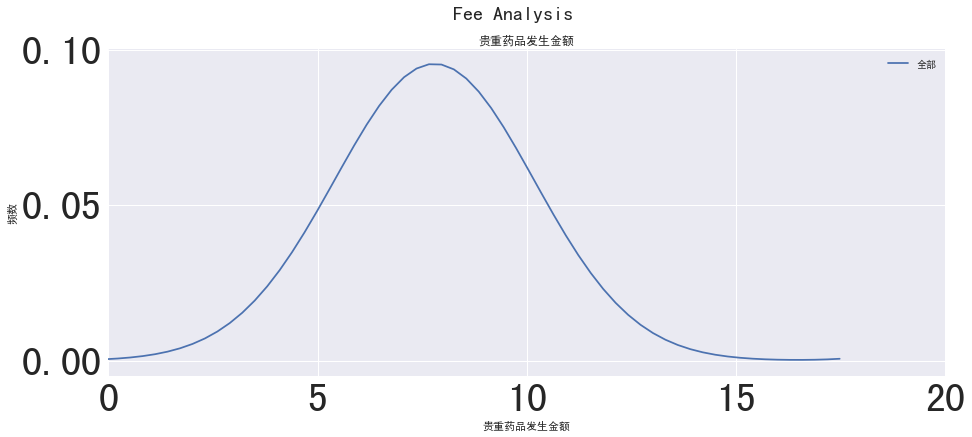

-2.16232501557


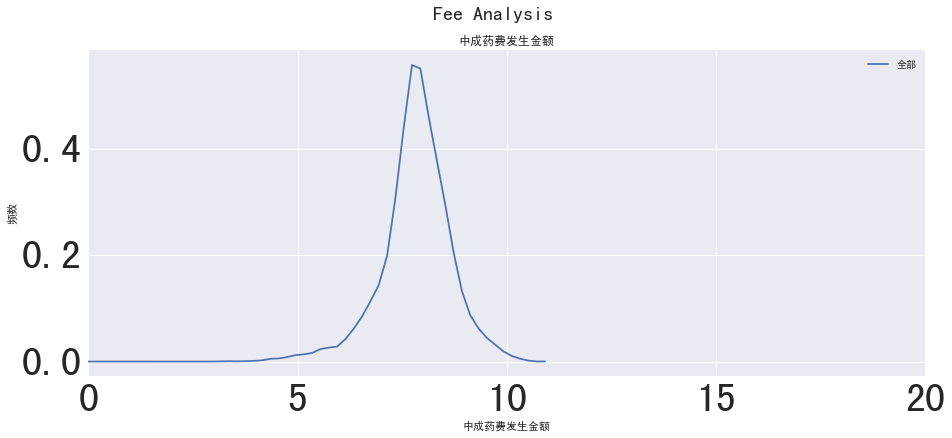

-0.1588767792


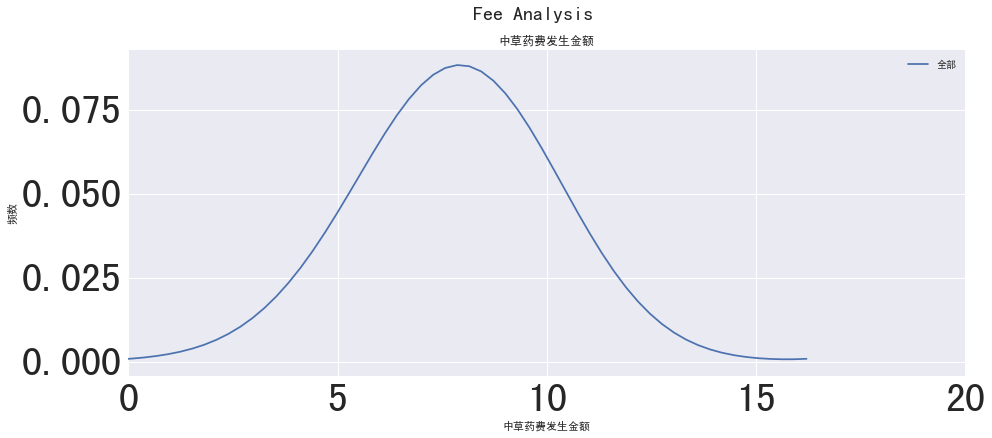

-0.505977281879


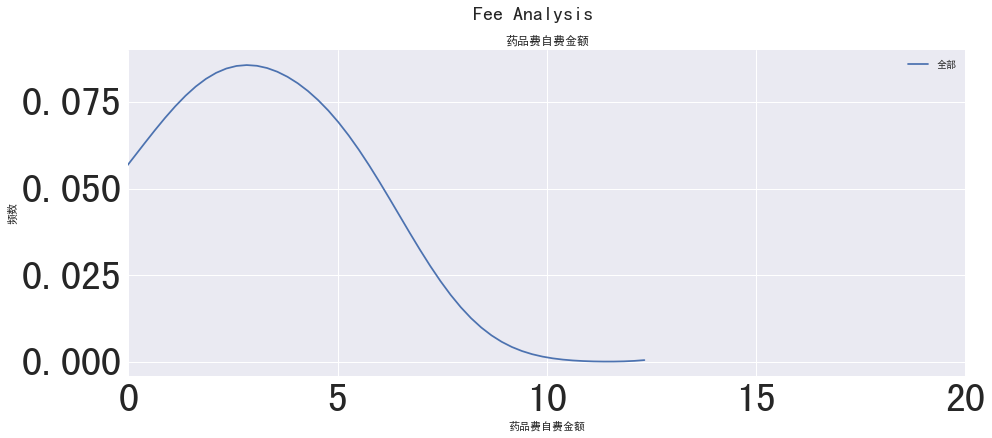

-10.9376761987


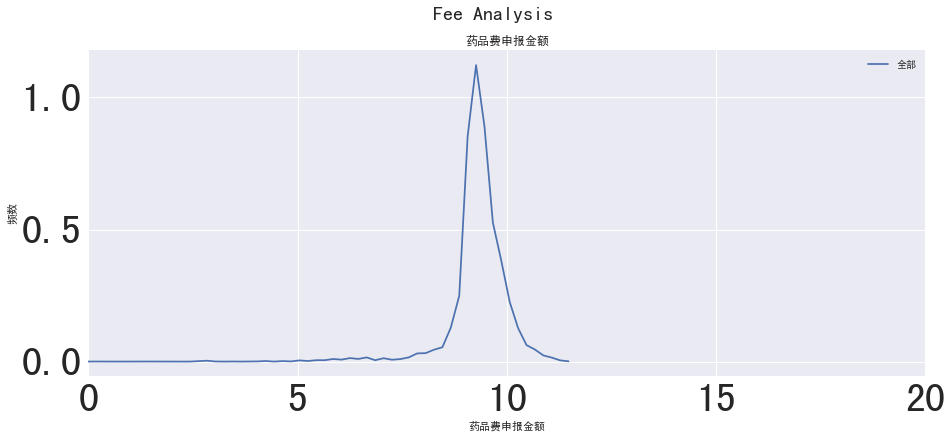

-1.15657024174


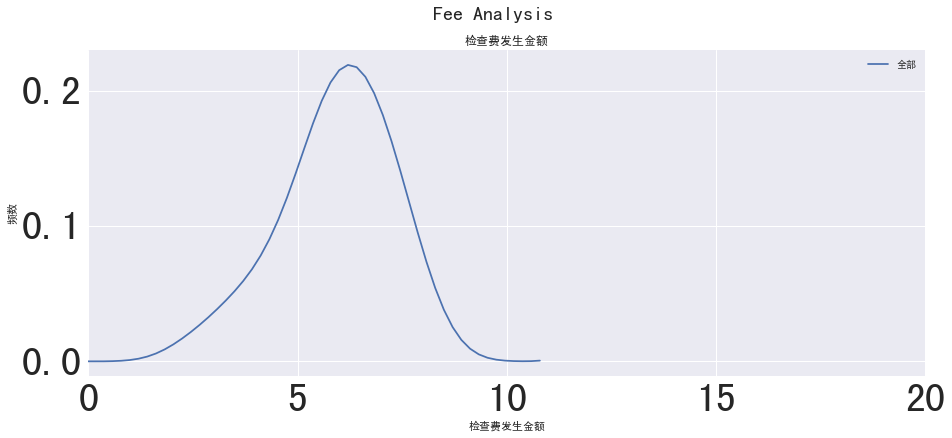

-1.15803376575


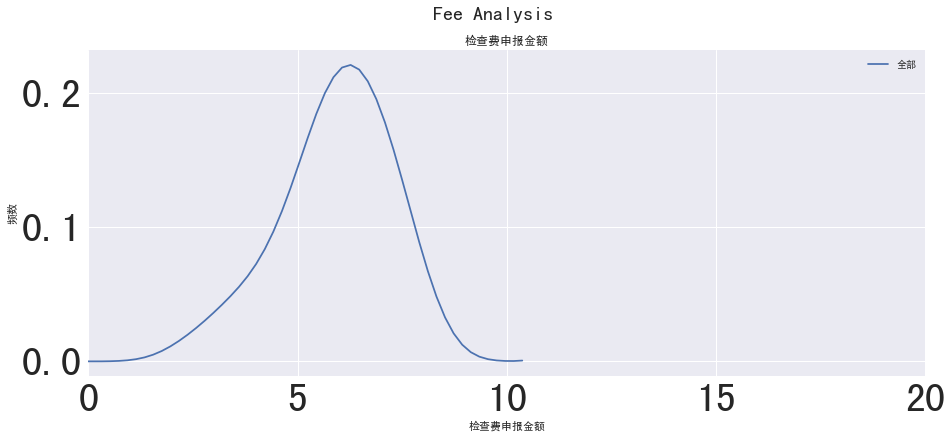

-4.06698831973


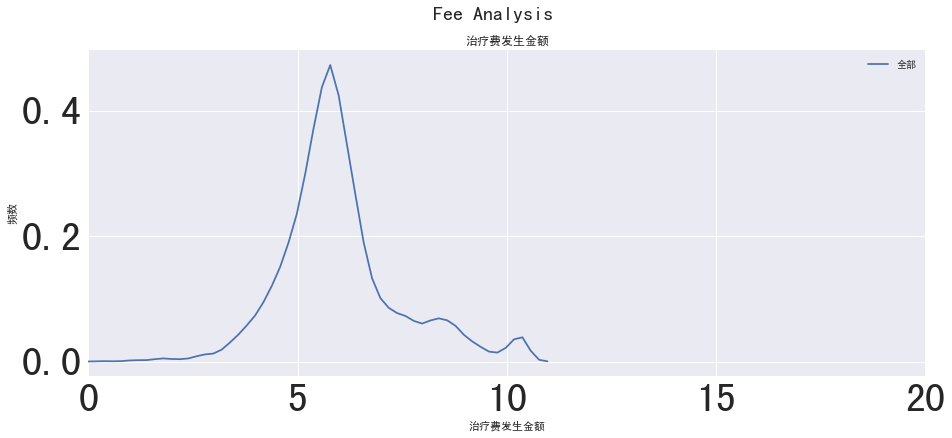

-3.84608556306


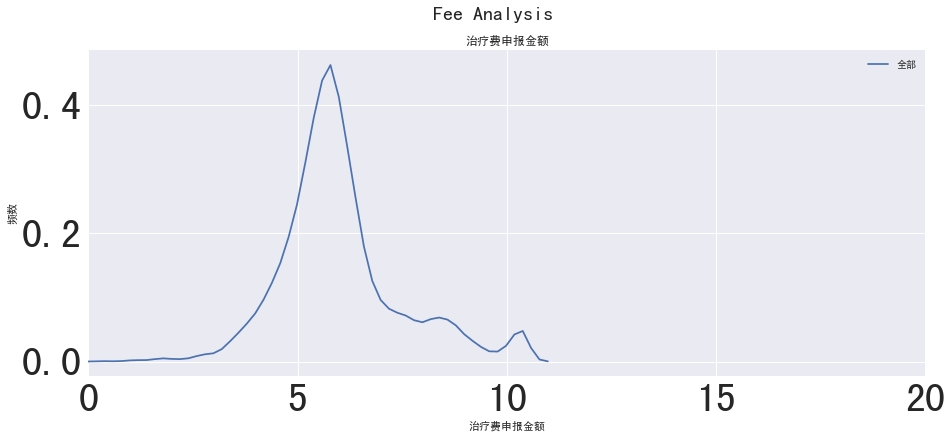

-1.36380038378


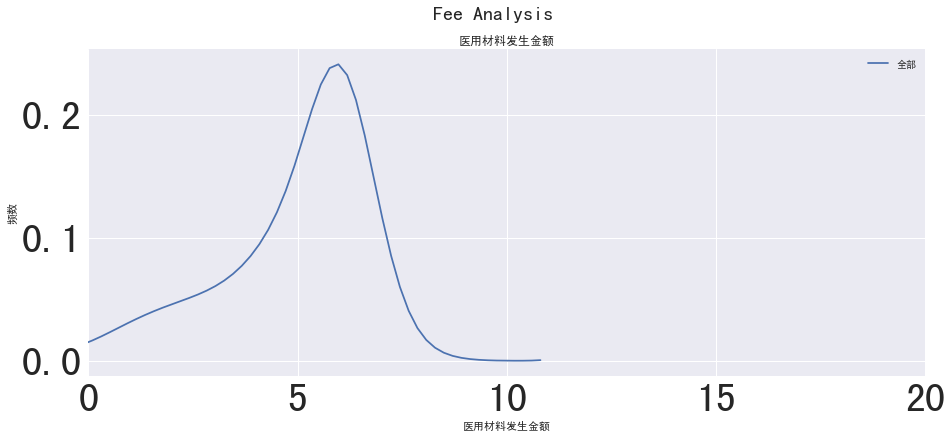

0.497828477304


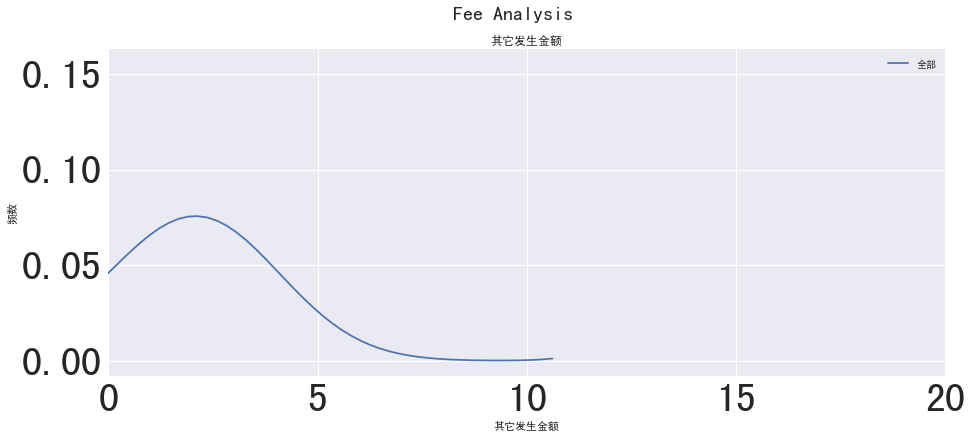

-1.06704145462


/home/zhh/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
/home/zhh/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


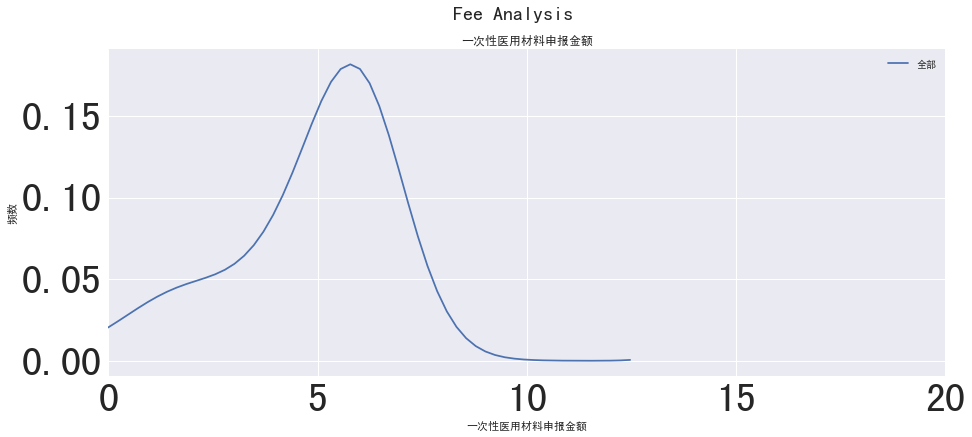

-10.2649399355


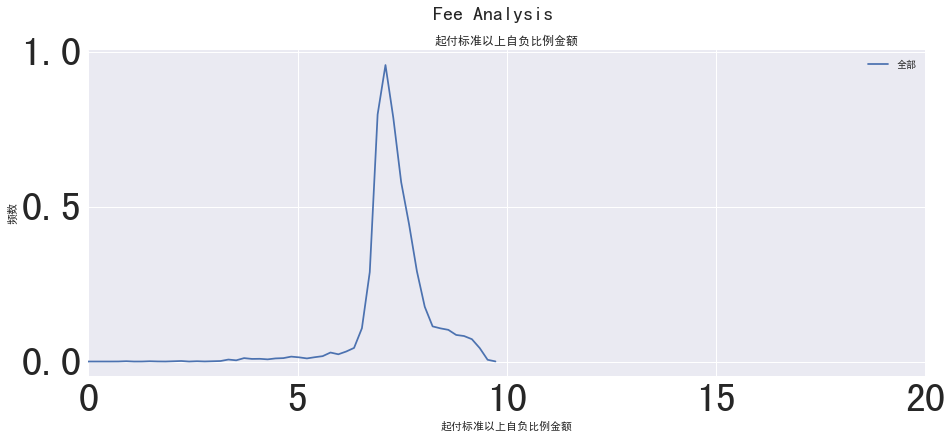

-13.5877692531


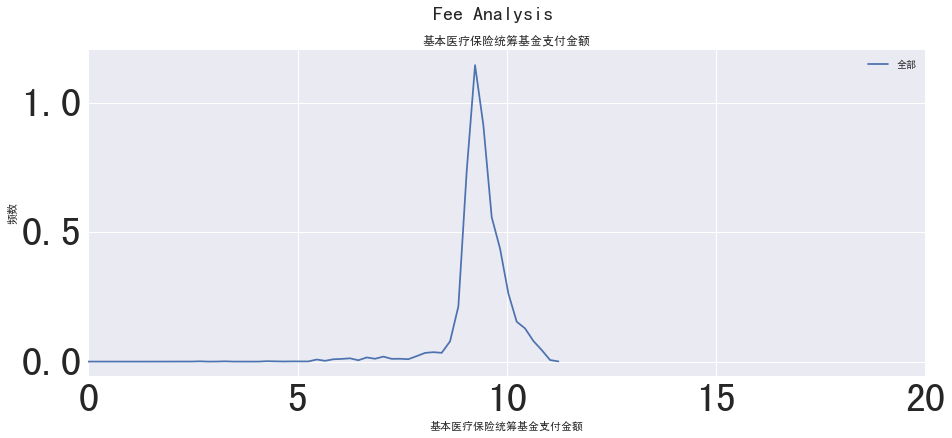

-3.79302446156


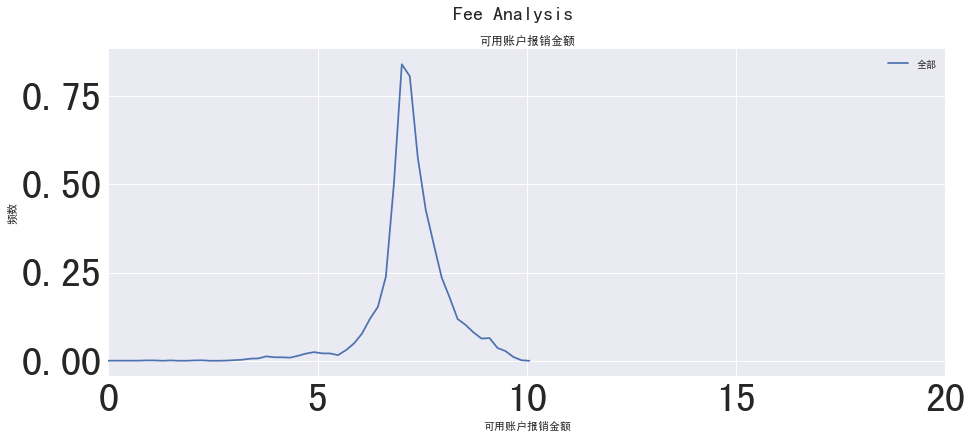

-0.522147022011


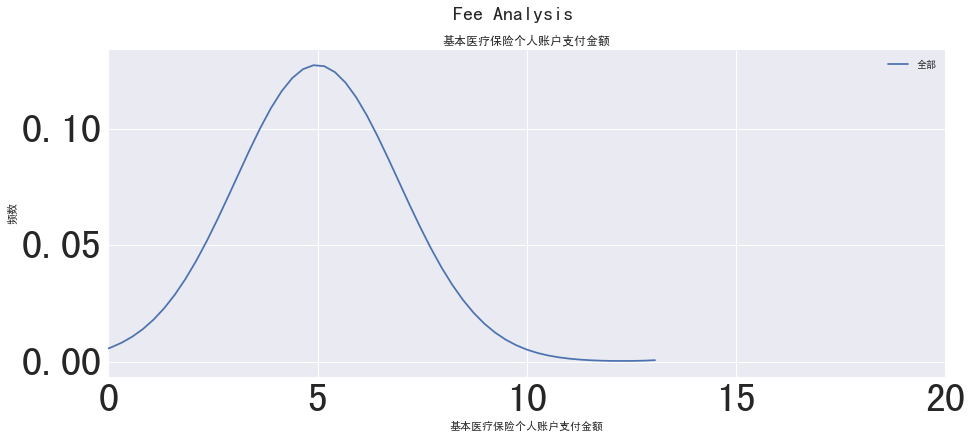

-7.55408126674


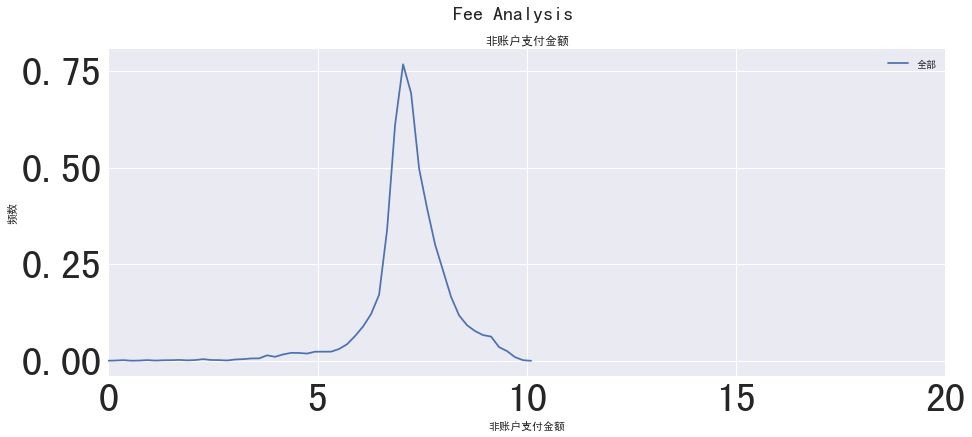

-2.04943968869


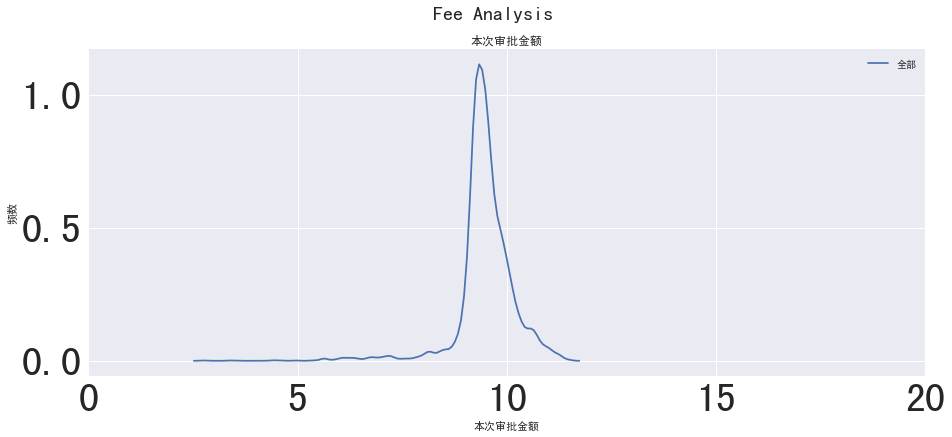

0.0640414566212


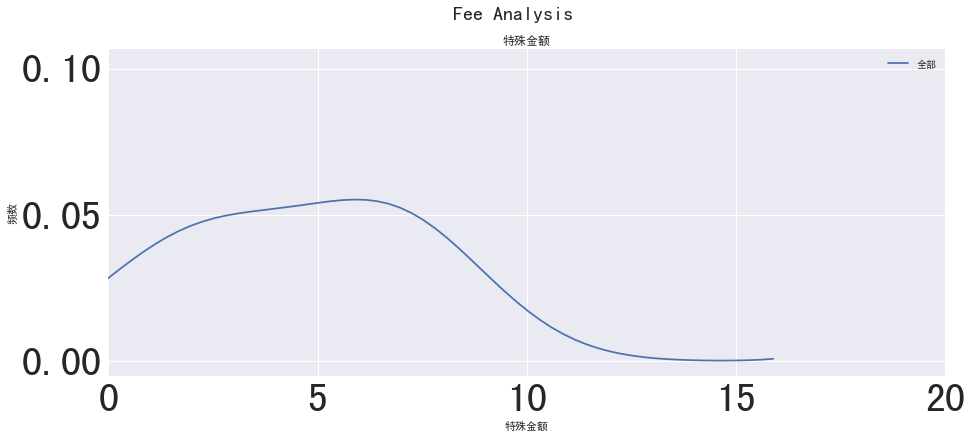

In [21]:
#给每一个金额画log图
for i in data_fee_new.columns:
    if '金额' in i:
        print(data_fee_new[i].skew())
        plot_log_fee(i,data_fee_new,0,20)


In [22]:
#写入7测试表合表
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('金额特征.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(data_fee_new,f1)

# 医院个数

In [25]:
#统计每个人对应的医院数
hs_cont = data.groupby('个人编码')['医院编码'].count()
hs_cont = hs_cont.reset_index()
hs_cont.columns =['个人编码','医院个数']
hs_cont.head()

,个人编码,医院个数
0,352120000001598,49
1,352120000004806,78
2,352120000005123,49
3,352120000006659,36
4,352120000010106,40


In [26]:
#写入医院个数
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('医院个数.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(hs_cont,f1)

# 探索出院病种的影响

In [27]:
disease = data[['个人编码','出院诊断病种名称']].drop_duplicates()
disease_cnt = disease.groupby('个人编码')['出院诊断病种名称'].count()
disease_cnt = disease_cnt.reset_index()

In [28]:
#关联
data_disease = pd.merge(disease_cnt,data[['个人编码']],how='left')
data_disease = data_disease.drop_duplicates()
data_disease = data_disease.reset_index(drop = True)
data_disease.columns=['个人编码','出院诊断病种名称个数']

In [30]:
data_disease.head()

,个人编码,出院诊断病种名称个数
0,352120000001598,5
1,352120000004806,6
2,352120000005123,4
3,352120000006659,2
4,352120000010106,2


In [31]:
#写入出院诊断病种的个数
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('出院诊断病种的个数.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(data_disease,f1)

# 研究时间的影响

In [5]:
# 
time_col_list =[]
for i in data.columns:
    if '时间' in i:
        time_col_list.append(i)
time_col_list

['交易时间', '住院开始时间', '住院终止时间', '申报受理时间', '操作时间']

In [6]:
data_time = data[['个人编码','交易时间', '住院开始时间', '住院终止时间', '申报受理时间', '操作时间']].drop_duplicates()

In [7]:
data_time_cnt = data_time.groupby(['个人编码'])['交易时间'].count().reset_index()
data_time_cnt.columns =['个人编码','交易次数']

In [8]:
data_time_cnt.head()

,个人编码,交易次数
0,352120000001598,23
1,352120000004806,37
2,352120000005123,21
3,352120000006659,13
4,352120000010106,19


In [37]:
#写入交易次数
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('交易次数.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(data_time_cnt,f1)

# 统计平均交易间隔

In [10]:
# 统计平均交易间隔
data_time_label = data_time[['个人编码','交易时间']].drop_duplicates()
data_time_label['交易时间']= pd.DatetimeIndex(pd.to_datetime(data_time_label['交易时间'])) #转换成时间格式

In [11]:
data_time_label.set_index('个人编码',inplace=True)

In [12]:
data_time_label.head()

,交易时间
个人编码,
352120001207726,2016-07-01
352120000183777,2016-07-01
352120002857717,2016-06-20
352120001492069,2016-07-01
352120001574938,2016-07-01


In [81]:
#编写获取交易频率的次数
def frequence(person_id,data_time_label):
    temp = data_time_label.loc[[person_id]]['交易时间']  #取数
    temp.dropna(inplace = True)
    a = temp.diff()    #求相隔次数
    max_day_delta = temp.iloc[-1] - temp.iloc[0]
    if a.shape[0] !=1:
        a.dropna(inplace=True)
        a = a.dt.days #变成实数型
        max_day_delta = max_day_delta.days
        freq = max_day_delta/temp.shape[0]        
        b =[[person_id,a.max(),a.mean(),a.median(),max_day_delta,freq ]]  #获取中位数或者平均值
    else:
        b=[[person_id,0,0,0,0,0]]
    b = pd.DataFrame(b)
    b.columns =['个人编码','交易间隔最大值','交易间隔平均值','交易间隔中位值','最大时间间隔','最大天数/次数']
    return b

In [82]:
%%time
#获得交易频率的dataframe
trade_f = None
for i in data_time_label.index.unique():
    try:
        a = frequence(i,data_time_label)
        trade_f = pd.concat([trade_f,a],axis=0)
    except:
        print(i)

/home/zhh/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2647: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


CPU times: user 4min, sys: 44 ms, total: 4min
Wall time: 4min 1s


In [83]:
#关联个人编码，带出标签
trade_f_label = pd.merge(trade_f,data[['个人编码']],how='left').drop_duplicates()
trade_f_label = trade_f_label.reset_index(drop=True)  #重置索引

In [85]:
trade_f_label.head()

,个人编码,交易间隔最大值,交易间隔平均值,交易间隔中位值,最大时间间隔,最大天数/次数
0,352120001207726,28,1.670103,2.0,162,1.653061
1,352120000183777,28,2.382353,2.0,162,2.347826
2,352120002857717,46,9.055556,7.0,163,8.578947
3,352120001492069,35,6.230769,4.5,162,6.000000
4,352120001574938,44,4.818182,5.0,159,4.676471


In [86]:
# 转换交易平均值和交易最大最大间隔
trade_f_label_new = trade_f_label[['个人编码','交易间隔平均值','交易间隔最大值']]
trade_f_label_new['交易间隔平均值'] = np.log(trade_f_label_new['交易间隔平均值']+0.00001)
trade_f_label_new['交易间隔最大值'] = np.log(trade_f_label_new['交易间隔最大值']+0.00001)


/home/zhh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/home/zhh/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,个人编码,交易间隔平均值,交易间隔最大值
0,352120001207726,0.512891,3.332205
1,352120000183777,0.868093,3.332205
2,352120002857717,2.203380,3.828642
3,352120001492069,1.829501,3.555348
4,352120001574938,1.572399,3.784190
5,352120001114553,1.280937,3.332205
6,352121000142166,2.257850,3.433988
7,352120000447733,2.472004,2.639058
8,352120000515129,2.510225,2.833214
9,352121000391830,2.140067,3.433988


In [87]:
trade_f_label_new.head()

,个人编码,交易间隔平均值,交易间隔最大值
0,352120001207726,0.512891,3.332205
1,352120000183777,0.868093,3.332205
2,352120002857717,2.203380,3.828642
3,352120001492069,1.829501,3.555348
4,352120001574938,1.572399,3.784190


In [88]:
#写入交易次数
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('交易间隔.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(trade_f_label_new,f1)

# 研究时间索引对天数的影响

In [14]:
data_time_label1 = data_time_label.copy()
data_time_label1['一个月的第几天'] =data_time_label['交易时间'].map(lambda x:x.day)
data_time_label1['一周星期几'] =data_time_label['交易时间'].map(lambda x:x.weekday_name)
data_time_label1.reset_index(inplace =True)

In [90]:
#****************天数**********************************
lam_func = lambda x: x.mode()[0] if x.mode().tolist()!=[] else random.choice(x.tolist())
#a = data_time_label1.groupby('个人编码')['一个月的第几天'].apply(lambda x:x.mode()[0] if x.mode().tolist() !=[] else random.choice(x.iloc[0]))
day_name = data_time_label1.groupby('个人编码')['一个月的第几天'].apply(lam_func)
day_name = pd.DataFrame(day_name)
day_name.reset_index(inplace=True)
day_name.drop_duplicates(inplace=True)
day_name.reset_index(inplace=True,drop = True)

In [93]:
def split_days(days):
    if days<=10:
        days = 1  # 上旬
    elif days> 10 and days<=20: #中旬
        days = 2
    else:
        days = 3   #中旬
    return days

day_name['上中下旬'] = day_name['一个月的第几天'].map(split_days)
day_name.head()

,个人编码,一个月的第几天,上中下旬
0,352120000001598,21.0,3
1,352120000004806,24.0,3
2,352120000005123,2.0,1
3,352120000006659,26.0,3
4,352120000010106,12.0,2


In [94]:
# #****************星期几**********************************
# lam_func = lambda x: x.mode()[0] if x.mode().tolist()!=[] else random.choice(x.tolist())
# #a = data_time_label1.groupby('个人编码')['一个月的第几天'].apply(lambda x:x.mode()[0] if x.mode().tolist() !=[] else random.choice(x.iloc[0]))
# week_name = data_time_label1.groupby('个人编码')['一周星期几'].apply(lam_func)
# week_name = pd.DataFrame(week_name)
# week_name.reset_index(inplace=True)
# week_name.drop_duplicates(inplace=True)
# week_name.reset_index(inplace=True,drop = True)

In [16]:
data_time_label2 = data_time_label1[['个人编码','一周星期几','交易时间']].drop_duplicates()
data_time_label2 = pd.get_dummies(data_time_label2,columns=['一周星期几'])
weekday_name = []
for i in data_time_label2.columns:
    if "星期" in i:
        weekday_name.append(i)
data_time_label2 = data_time_label2.groupby("个人编码")[weekday_name].sum()
data_time_label2.reset_index(inplace=True)

In [17]:
data_time_label2.head()

,个人编码,一周星期几_Friday,一周星期几_Monday,一周星期几_Saturday,一周星期几_Sunday,一周星期几_Thursday,一周星期几_Tuesday,一周星期几_Wednesday
0,352120000001598,3,3,2,1,4,5,5
1,352120000004806,4,9,1,0,9,8,6
2,352120000005123,12,6,1,0,1,0,1
3,352120000006659,1,3,0,0,2,5,2
4,352120000010106,4,4,2,4,2,0,3


In [18]:
data_time_label2.to_pickle('/home/zhh/文档/阿里巴巴/data/7测试表合表/新周表.pickle')

In [96]:
# if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
#     os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
# else:
#     os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
#     os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
# with open('天索引.pickle','wb') as f1:
#     #data = pickle.load(f1)  
#     pickle.dump(day_name,f1)
    
# with open('周索引.pickle','wb') as f1:
#     #data = pickle.load(f1)  
#     pickle.dump(week_name,f1)

# 出院病种

In [97]:

def convert_diease_name(name):
    diease_types = []
    
    #1挂号
    if name =='挂号':
        guahao =1
    else:
        guahao =0
        
    #2空值
    if name =='空值':
        kongzhi = 1
    else:
        kongzhi = 0
    
    #3肾病
    if any(word in name for word in ['肾','透析','蛋白尿','尿毒']):
        shenbing = 1
    else:
        shenbing =0
    
    #4门特
    if '门特' in name:
        mente = 1
    else:
        mente =0
    
    #5心血管病
    if  any(word in name for word in ['心脏','冠心','血管','粥样','动脉','粘稠'\
                                     ,'脂','血糖','心肌']):
        xinxueguan = 1
    else:
        xinxueguan = 0
        
    #6脑血管病
    if any(word in name for word in ['癫痫','偏瘫','脑','中风']):
        naoxueguan = 1
    else:
        naoxueguan = 0
        
    #7癌症
    if any(word in name for word in ['癌','肿瘤','放疗','化疗'\
                                     ,'放化疗','白血病','Ca','ca','cancer','白血病']):
        aizheng = 1
    else:
        aizheng = 0
        
    #8肺病
    if any(word in name for word in ['肺','结核']):
        feibing = 1
    else:
        feibing = 0
    
    #9糖尿病
    if any(word in name for word in ['糖尿','胰岛素']):
        tangniaobing = 1
    else:
        tangniaobing = 0
    
     #10神经病
    if any(word in name for word in ['神经']):
        shenjingbing = 1
    else:
        shenjingbing = 0
        
    #11精神病
    if  any(word in name for word in ['精神']):
        jinshenbing = 1
    else:
        jinshenbing = 0
    
    #12高血压
    if any(word in name for word in ['高血压']):
        gaoxueya = 1
    else:
        gaoxueya = 0
    
    
    #13病变
    if '病变' in name:
        bingbian = 1
    else:
         bingbian = 0 
            
    
    #14偏瘫
    if any(word in name for word in ['偏瘫']):
        piantan = 1
    else:
        piantan = 0 
    
    #心脏
    if any(word in name for word in ['心脏','冠心','肺心']):
        xinzangbing = 1
    else:
        xinzangbing = 0
   
    
     #肺心病
    if any(word in name for word in ['肺心']):
        feixinbing = 1
    else:
        feixinbing = 0
        
    #肾性
    if any(word in name for word in ['肾性']):
        shenxin = 1
    else:
        shenxin = 0
        
    #合并
    if any(word in name for word in ['合并']):
        hebing = 1
    else:
        hebing = 0
        
    #肾病1
    if any(word in name for word in ['肾病']):
        shenbing1 = 1
    else:
        shenbing1 =0
    
    
    #15其他
    qita_list =['挂号','空值','肾','透析','蛋白尿','尿毒','门特'\
               ,'心脏','冠心','血管','粥样','动脉','粘稠','脂','血糖'\
               ,'癫痫','偏瘫','脑','中风','癌','肿瘤','放疗','化疗'\
                ,'放化疗','白血病','Ca','ca','cancer','白血病','肺','结核',\
               '糖尿','胰岛素','神经','精神','高血压','偏瘫','心脏','冠心','肺心','心肌','肾性','合并','肾病']
    
    if all(word not in i for word in qita_list):
        qita = 1
    else:
        qita =0
        
    diease_types.append([guahao,kongzhi,shenbing, mente,xinxueguan,naoxueguan,\
                         aizheng,feibing,tangniaobing,shenjingbing,jinshenbing,gaoxueya,\
                       bingbian,piantan,xinzangbing,feixinbing,shenxin,hebing,shenbing1,qita])

    return diease_types

In [99]:
# 提取出院病种名称
diease_name = data[['个人编码','出院诊断病种名称']].drop_duplicates()
#将空值类命名为空值类
diease_name['出院诊断病种名称'] = diease_name['出院诊断病种名称'].fillna('空值')

In [100]:
#生成不同分类的病种
diease_columns =[['挂号','空值','肾病','门特','心血管病','脑血管病'\
              ,'癌症','肺病','糖尿病','神经病','精神病','高血压','病变','偏瘫','心脏病','肺心病','肾性','合并','肾病1','其他']]

for i in diease_name['出院诊断病种名称']:
    a = convert_diease_name(i)
    diease_columns.append(a[0])

In [101]:
#生成Dataframe
diease_columns = pd.DataFrame(diease_columns[1:],columns = diease_columns[0])

In [102]:
#连接diease_name.
diease_name_new = pd.concat([diease_name.reset_index(drop=True),diease_columns],axis=1).drop_duplicates()
diease_name_new0 =diease_name_new[['个人编码','挂号','空值'
                                  ,'肾病','门特','心血管病','脑血管病','癌症','肺病'
                                  ,'糖尿病','神经病','精神病','高血压','病变','偏瘫',
                                   '心脏病','肺心病','肾性','合并','肾病1','其他']]

In [103]:
diease_name_result = diease_name_new0.groupby('个人编码').sum().reset_index(inplace = False)
diease_name_result.head()

,个人编码,挂号,空值,肾病,门特,心血管病,脑血管病,癌症,肺病,糖尿病,...,精神病,高血压,病变,偏瘫,心脏病,肺心病,肾性,合并,肾病1,其他
0,352120000001598,1,1,1,1,1,0,0,0,4,...,0,0,2,0,0,0,0,2,0,0
1,352120000004806,1,1,0,0,4,5,0,0,0,...,0,2,0,4,0,0,0,0,0,0
2,352120000005123,1,1,0,1,1,0,0,0,2,...,0,0,0,0,1,0,0,0,0,0
3,352120000006659,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,352120000010106,1,1,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [104]:
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('出院诊断病种分词将结果.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(diease_name_result,f1)


# 研究fee_tail

In [105]:
fee_detail = pd.read_csv('/home/zhh/文档/阿里巴巴/data/fee_detail.csv')

/home/zhh/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [106]:
fee_detail['医院编码'] = fee_detail['医院编码'].map(lambda x:str(x).split(".")[0])

In [107]:
fee_detail.head()

,顺序号,医院编码,三目统计项目,三目服务项目名称,三目医院服务项目名称,剂型,规格,单价,数量,拒付原因编码,拒付原因,费用发生时间
0,MT13061601133880864,1306,7.0,普通门诊挂号费---三级医院,挂号,,,1.0,1.0,NaN,NaN,2016-01-13
1,MT13061601133880864,1306,3.0,NaN,挂号,,,3.0,1.0,NaN,NaN,2016-01-13
2,MT13061601154123666,1306,3.0,NaN,挂号,,,3.0,1.0,NaN,NaN,2016-01-15
3,MT13061601154123666,1306,7.0,普通门诊挂号费---三级医院,挂号,,,1.0,1.0,NaN,NaN,2016-01-15
4,MT13061602298982056,1306,7.0,普通门诊挂号费---三级医院,挂号,,,1.0,1.0,NaN,NaN,2016-02-29


In [112]:
data['医院编码'] = data['医院编码'].map(lambda x:str(x).split(".")[0])
fee_detail_label = pd.merge(data[['顺序号','个人编码','医院编码']],fee_detail
         ,left_on = ['顺序号','医院编码'],right_on=['顺序号','医院编码'],how='left')
fee_detail_label = fee_detail_label.drop_duplicates()  #去重

In [113]:
fee_detail_label.head()

,顺序号,个人编码,医院编码,三目统计项目,三目服务项目名称,三目医院服务项目名称,剂型,规格,单价,数量,拒付原因编码,拒付原因,费用发生时间
0,MT01801607015822867,352120001207726,180,3.0,NaN,NaN,,,6.0,1.0,NaN,NaN,2016-07-01
1,MT01801607015822875,352120000183777,180,3.0,NaN,NaN,,,3.0,1.0,NaN,NaN,2016-07-01
2,MT01801607015822882,352120000183777,180,3.0,NaN,NaN,,,460.0,1.0,NaN,NaN,2016-07-01
3,MT13061606204620197,352120002857717,1306,7.0,普通门诊挂号费---三级医院,挂号,,,1.0,1.0,NaN,NaN,2016-06-20
4,MT13061606204620197,352120002857717,1306,3.0,NaN,挂号,,,3.0,1.0,NaN,NaN,2016-06-20


In [114]:
#统计空值
np.sum(fee_detail_label.isnull())

顺序号                0
个人编码               0
医院编码               0
三目统计项目             0
三目服务项目名称      818343
三目医院服务项目名称    810260
剂型                 0
规格                 0
单价                 0
数量                 0
拒付原因编码        934132
拒付原因          934132
费用发生时间             0
dtype: int64

In [116]:
#删除拒付原因编码和拒付原因
fee_detail_label.drop(['拒付原因编码','拒付原因'],axis=1,inplace=True)

In [117]:
fee_detail_label.head()

,顺序号,个人编码,医院编码,三目统计项目,三目服务项目名称,三目医院服务项目名称,剂型,规格,单价,数量,费用发生时间
0,MT01801607015822867,352120001207726,180,3.0,NaN,NaN,,,6.0,1.0,2016-07-01
1,MT01801607015822875,352120000183777,180,3.0,NaN,NaN,,,3.0,1.0,2016-07-01
2,MT01801607015822882,352120000183777,180,3.0,NaN,NaN,,,460.0,1.0,2016-07-01
3,MT13061606204620197,352120002857717,1306,7.0,普通门诊挂号费---三级医院,挂号,,,1.0,1.0,2016-06-20
4,MT13061606204620197,352120002857717,1306,3.0,NaN,挂号,,,3.0,1.0,2016-06-20


In [118]:
#删除顺序号再去重
fee_detail_label.drop('顺序号',axis=1,inplace=True)
fee_detail_label.drop_duplicates(inplace=True)
fee_detail_label.shape

(906527, 10)

In [119]:
# 将nan值填充为空值
fee_detail_label['三目服务项目名称'] = fee_detail_label['三目服务项目名称'].fillna('空值')

In [120]:
def convert_diease_name(name):
    diease_types = []
      
    #1空值
    if name =='空值':
        kongzhi = 1
    else:  
        kongzhi = 0
    
    #3普通门诊 
    if any(word in name for word in ['普通门诊']):
        ptmz = 1
    else:
        ptmz = 0
    
    
    #5糖尿病门诊
    if  any(word in name for word in ['糖尿病门诊']):
        tnbmz = 1
    else:
        tnbmz = 0
        
    #6其他门诊
    if '门诊' in name and all(word not in name for word in ['糖尿病门诊','普通门诊']):
        qtmz = 1 
    else:
        qtmz  = 0
        
    #7乙肝
    if any(word in name for word in ['乙肝']):
        yigan = 1
    else:
        yigan = 0
        
    #肝素钙
    if any(word in name for word in ['肝素钙']):
        gansugai = 1
    else:
        gansugai = 0 
    
    #脑心通胶囊
    if any(word in name for word in ['脑心通']):
        nxtjn= 1
    else:
         nxtjn = 0 
    
     #1通心络   
    if any(word in name for word in ['通心络']):
        txljn = 1
    else:
        txljn = 0
        
    if '胶囊' in name and all(word not in name for word in ['通心络','脑心通']):
        qtjn = 1
    else: 
        qtjn  = 0
   
    
    #15其他
    qita_list =[ '空值','普通门诊','糖尿病门诊','乙肝','肝素钙','脑心通','通心络','胶囊','门诊']
    
    if all(word not in i for word in qita_list):
        qita = 1
    else:
        qita =0
        
    diease_types.append([kongzhi, ptmz, tnbmz,qtmz,yigan,gansugai,nxtjn,txljn,qtjn,qita])

    return diease_types

In [121]:
##*****************三目服务项目名称**********************************
diease_columns =[['三目空值','普通门诊','糖尿病门诊','其他门诊','乙肝','肝素钙','脑心通胶囊','通心络胶囊','其他胶囊','三目其他']]

for i in fee_detail_label['三目服务项目名称']:
    a = convert_diease_name(i)
    diease_columns.append(a[0])

#生成Dataframe
diease_columns = pd.DataFrame(diease_columns[1:],columns = diease_columns[0])

#连接diease_name.
diease_name_new = pd.concat([fee_detail_label.reset_index(drop=True)
                             ,diease_columns.reset_index(drop=True)],axis=1).drop_duplicates()
diease_name_new0 =diease_name_new[['个人编码','三目空值','普通门诊','糖尿病门诊','其他门诊',
                                   '乙肝','肝素钙','脑心通胶囊','通心络胶囊','其他胶囊','三目其他']]

diease_name_new0

diease_name_new = diease_name_new0.groupby('个人编码').sum().reset_index(inplace = False)


In [122]:
#总价的影响
fee_detail_label ['总价'] = fee_detail_label['单价']  * fee_detail_label['数量']

In [123]:
fee_sum = fee_detail_label.groupby('个人编码',as_index=False)['总价'].sum()

In [125]:
fee_sum.drop_duplicates(inplace=True)

In [126]:
#  三表相联保存
temp = pd.merge(diease_name_new,fee_sum,how= 'left')

In [127]:
temp['总价'] = np.log(temp['总价']+0.0001)

In [128]:
sanmu_cont  = fee_detail_label[['个人编码','三目统计项目']].drop_duplicates()
sanmu_cont = sanmu_cont.groupby(['个人编码'])[['三目统计项目']].count()
sanmu_cont.reset_index(inplace=True)

In [129]:
# 连接三目统计表
fee_detail_result = pd.merge(temp,sanmu_cont,how='left')

In [130]:
fee_detail_result.head()

,个人编码,三目空值,普通门诊,糖尿病门诊,其他门诊,乙肝,肝素钙,脑心通胶囊,通心络胶囊,其他胶囊,三目其他,总价,三目统计项目
0,352120000001598,128,8,16,0,0,0,0,0,0,2,9.259740,5
1,352120000004806,161,37,0,0,0,0,5,0,0,0,9.465761,3
2,352120000005123,176,10,11,0,0,0,0,0,0,0,9.388239,4
3,352120000006659,192,0,0,0,0,0,0,0,0,0,9.188587,3
4,352120000010106,120,11,8,0,0,0,0,0,0,0,9.075157,5


In [131]:
if os.path.exists('/home/zhh/文档/阿里巴巴/data/7测试表合表'):
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
else:
    os.mkdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
    os.chdir('/home/zhh/文档/阿里巴巴/data/7测试表合表')
with open('金额细节.pickle','wb') as f1:
    #data = pickle.load(f1)  
    pickle.dump(fee_detail_result,f1)

# 合并表

In [132]:
import pandas as pd
import numpy as np
import os
import re
import warnings
import pickle
import os.path
import seaborn
import pickle
import os.path
from numpy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import jieba


mpl.rcParams.update({'font.size': 30})

mpl.rcParams['font.sans-serif'] = ['SimHei']
mpl.rcParams['font.serif'] = ['SimHei']

import seaborn as sns
#sns.set_style('whitegrid',{'font.sans-serif':['simhei','Arial']})
sns.set_style("darkgrid",{"font.sans-serif":['simhei', 'Arial']})
#plt.style.use('ggplot')
mpl.rc('xtick', labelsize=20) 
mpl.rc('ytick', labelsize=20) 
%matplotlib inline

In [133]:
os.chdir("/home/zhh/文档/阿里巴巴/data/7测试表合表/")
os.listdir()

['金额特征.pickle',
 '金额细节.pickle',
 '出院诊断病种分词将结果.pickle',
 '医院个数.pickle',
 '出院诊断病种的个数.pickle',
 '周索引.pickle',
 '天索引.pickle',
 '交易间隔.pickle',
 '交易次数.pickle']

In [134]:
fee_feature = pd.read_pickle("金额特征.pickle")
fee_feature.head()

,个人编码,药品费发生金额,贵重药品发生金额,中成药费发生金额,中草药费发生金额,药品费自费金额,药品费申报金额,检查费发生金额,检查费申报金额,治疗费发生金额,...,医用材料发生金额,其它发生金额,一次性医用材料申报金额,起付标准以上自负比例金额,基本医疗保险统筹基金支付金额,可用账户报销金额,基本医疗保险个人账户支付金额,非账户支付金额,本次审批金额,特殊金额
0,352120000001598,9.171610,-13.815511,7.838375,6.543451,5.346965,9.145449,5.594711,5.594711,6.138806,...,5.134621,-13.815511,5.134621,6.934787,9.132010,6.971519,4.893202,7.040913,9.237371,-13.815511
1,352120000004806,9.154141,-13.815511,7.158031,8.114642,3.510650,9.148880,-13.815511,-13.815511,8.171882,...,-13.815511,-13.815511,-13.815511,7.165779,9.363021,7.178172,5.273000,7.046630,9.468380,-13.815511
2,352120000005123,9.347537,8.357170,6.363855,7.596473,-13.815511,9.347537,5.099866,5.099866,5.895779,...,-13.815511,2.995732,-13.815511,7.089918,9.287138,7.089918,4.735057,7.008451,9.392499,-13.815511
3,352120000006659,9.529905,8.758595,8.758595,8.909251,-13.815511,9.529905,-13.815511,-13.815511,4.262680,...,-13.815511,-13.815511,-13.815511,7.232430,9.429693,7.232430,4.553877,7.161296,9.535049,-13.815511
4,352120000010106,8.960440,-13.815511,7.951408,5.549893,-1.560643,8.957095,4.859812,4.859812,5.065755,...,5.798001,-13.815511,5.798001,6.731018,8.928231,6.761341,4.617593,6.636943,9.033592,-13.815511


In [135]:
fee_detail = pd.read_pickle("金额细节.pickle")

# 修改一下fee_detail的总价和三目统计项目
fee_detail = fee_detail.rename(columns = {"总价":"三目项目总价","三目统计项目":"三目统计项目总计和"})
fee_detail.head()

,个人编码,三目空值,普通门诊,糖尿病门诊,其他门诊,乙肝,肝素钙,脑心通胶囊,通心络胶囊,其他胶囊,三目其他,三目项目总价,三目统计项目总计和
0,352120000001598,128,8,16,0,0,0,0,0,0,2,9.259740,5
1,352120000004806,161,37,0,0,0,0,5,0,0,0,9.465761,3
2,352120000005123,176,10,11,0,0,0,0,0,0,0,9.388239,4
3,352120000006659,192,0,0,0,0,0,0,0,0,0,9.188587,3
4,352120000010106,120,11,8,0,0,0,0,0,0,0,9.075157,5


In [136]:
# 金额特征和金额细节合并成fee表
fee = pd.merge(fee_feature,fee_detail,how='left',left_on=['个人编码'],right_on=['个人编码'])
fee.head()

,个人编码,药品费发生金额,贵重药品发生金额,中成药费发生金额,中草药费发生金额,药品费自费金额,药品费申报金额,检查费发生金额,检查费申报金额,治疗费发生金额,...,糖尿病门诊,其他门诊,乙肝,肝素钙,脑心通胶囊,通心络胶囊,其他胶囊,三目其他,三目项目总价,三目统计项目总计和
0,352120000001598,9.171610,-13.815511,7.838375,6.543451,5.346965,9.145449,5.594711,5.594711,6.138806,...,16,0,0,0,0,0,0,2,9.259740,5
1,352120000004806,9.154141,-13.815511,7.158031,8.114642,3.510650,9.148880,-13.815511,-13.815511,8.171882,...,0,0,0,0,5,0,0,0,9.465761,3
2,352120000005123,9.347537,8.357170,6.363855,7.596473,-13.815511,9.347537,5.099866,5.099866,5.895779,...,11,0,0,0,0,0,0,0,9.388239,4
3,352120000006659,9.529905,8.758595,8.758595,8.909251,-13.815511,9.529905,-13.815511,-13.815511,4.262680,...,0,0,0,0,0,0,0,0,9.188587,3
4,352120000010106,8.960440,-13.815511,7.951408,5.549893,-1.560643,8.957095,4.859812,4.859812,5.065755,...,8,0,0,0,0,0,0,0,9.075157,5


In [137]:
cyzd = pd.read_pickle("出院诊断病种分词将结果.pickle")
cyzd.head()

,个人编码,挂号,空值,肾病,门特,心血管病,脑血管病,癌症,肺病,糖尿病,...,精神病,高血压,病变,偏瘫,心脏病,肺心病,肾性,合并,肾病1,其他
0,352120000001598,1,1,1,1,1,0,0,0,4,...,0,0,2,0,0,0,0,2,0,0
1,352120000004806,1,1,0,0,4,5,0,0,0,...,0,2,0,4,0,0,0,0,0,0
2,352120000005123,1,1,0,1,1,0,0,0,2,...,0,0,0,0,1,0,0,0,0,0
3,352120000006659,1,1,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,352120000010106,1,1,1,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,1,0


In [138]:
cyzd.columns=['个人编码','挂号次数和','空值次数和','肾病次数和','门特次数和','心血管病次数和',
 '脑血管病次数和','癌症次数和','肺病次数和','糖尿病次数和','神经病次数和','精神病次数和','高血压次数和',
 '病变次数和','偏瘫次数和','心脏病次数和','肺心病次数和', '肾性次数和','合并次数和','肾病1次数和','其他次数和']

In [139]:
# 合并出院诊断病种
fee_cyzd = pd.merge(fee,cyzd,how='left')

In [140]:
hs_cont = pd.read_pickle("出院诊断病种的个数.pickle")

In [141]:
#合并出院诊断病种个数
fee_hs_cyzd=pd.merge(fee_cyzd,hs_cont,how ='left')

In [142]:
zhou = pd.read_pickle('周索引.pickle')
tian = pd.read_pickle('天索引.pickle')
jyjg=pd.read_pickle('交易间隔.pickle')
jycs = pd.read_pickle('交易次数.pickle')

In [144]:
data0 = pd.merge(fee_hs_cyzd,zhou,how='left')

data1 =pd.merge(data0,tian[["个人编码","上中下旬"]],how = 'left')

data2 = pd.merge(data1,jyjg,how='left')

data3 = pd.merge(data2,jycs,how='left')

data3.to_pickle("测试集总表v1.pickle")

In [146]:
data3.shape

(4000, 59)

In [147]:
hs_count=pd.read_pickle("医院个数.pickle")

In [148]:
data4 = pd.merge(data3,hs_count,how='left')

In [149]:
data4.to_pickle("测试集总表v2.pickle")

# 20170810 --23:39删除旧周表，添加新周表

In [22]:
data4 = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/测试集总表v2.pickle")
new_weekname = pd.read_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/新周表.pickle")

In [25]:
data4.drop(["一周星期几"],axis=1,inplace=True)

In [27]:
data5 = pd.merge(data4,new_weekname,how='left')

In [30]:
data5.head()
data5.to_pickle("/home/zhh/文档/阿里巴巴/data/7测试表合表/测试集总表v3.pickle")